# Tarea 7

### Optimizacion Convexa

Juan Diego Sánchez Torres

Alumnos:
Juan Mario Ochoa Navarro
Zurisadai Velázquez Manzanero
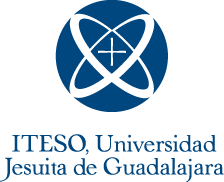


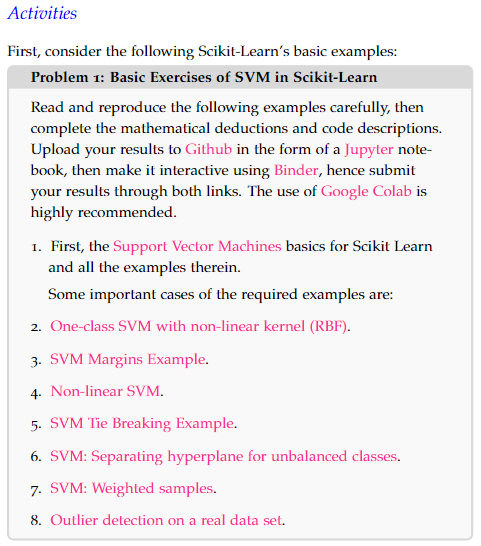

# 1. SVM
# -----------------------------------------------------------------------------------------------------------

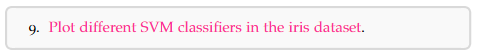

# Classification

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

Effective in high dimensional spaces.

Still effective in cases where number of dimensions is greater than the number of samples.

Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

The support vector machines in scikit-learn support both dense (numpy.ndarray and convertible to that by numpy.asarray) and sparse (any scipy.sparse) sample vectors as input. However, to use an SVM to make predictions for sparse data, it must have been fit on such data. For optimal performance, use C-ordered numpy.ndarray (dense) or scipy.sparse.csr_matrix (sparse) with dtype=float64.

SVC, NuSVC and LinearSVC are classes capable of performing binary and multi-class classification on a dataset.

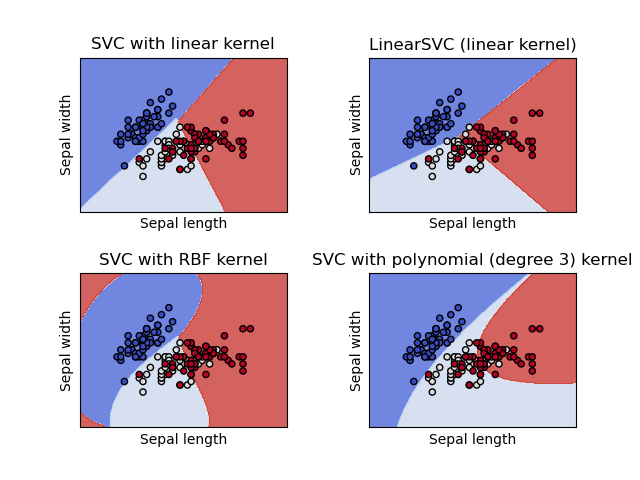

SVC and NuSVC are similar methods, but accept slightly different sets of parameters and have different mathematical formulations (see section Mathematical formulation). On the other hand, LinearSVC is another (faster) implementation of Support Vector Classification for the case of a linear kernel. Note that LinearSVC does not accept parameter kernel, as this is assumed to be linear. It also lacks some of the attributes of SVC and NuSVC, like support_.

As other classifiers, SVC, NuSVC and LinearSVC take as input two arrays: an array X of shape (n_samples, n_features) holding the training samples, and an array y of class labels (strings or integers), of shape (n_samples):

In [3]:
from sklearn import svm
X = [[0, 0], [1, 1]]
y = [0, 1]
clf = svm.SVC()
clf.fit(X, y)

SVC()

After being fitted, the model can then be used to predict new values:

In [4]:
clf.predict([[2., 2.]])

array([1])

SVMs decision function (detailed in the Mathematical formulation) depends on some subset of the training data, called the support vectors. Some properties of these support vectors can be found in attributes support_vectors_, support_ and n_support_:

In [6]:
# Support vectors
clf.support_vectors_

 # get indices of support vectors
clf.support_

# get number of support vectors for each class
clf.n_support_


array([1, 1])

# Multi-class classification

SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes).

In [7]:
X = [[0], [1], [2], [3]]
Y = [0, 1, 2, 3]
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, Y)

dec = clf.decision_function([[1]])
dec.shape[1] # 4 classes: 4*3/2 = 6

clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
dec.shape[1] # 4 classes


4

On the other hand, LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training n_classes models.



In [8]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X, Y)

dec = lin_clf.decision_function([[1]])
dec.shape[1]



4

See Mathematical formulation for a complete description of the decision function.

Note that the LinearSVC also implements an alternative multi-class strategy, the so-called multi-class SVM formulated by Crammer and Singer 16, by using the option multi_class='crammer_singer'. In practice, one-vs-rest classification is usually preferred, since the results are mostly similar, but the runtime is significantly less.

For “one-vs-rest” LinearSVC the attributes coef_ and intercept_ have the shape (n_classes, n_features) and (n_classes,) respectively. Each row of the coefficients corresponds to one of the n_classes “one-vs-rest” classifiers and similar for the intercepts, in the order of the “one” class.

In the case of “one-vs-one” SVC and NuSVC, the layout of the attributes is a little more involved. In the case of a linear kernel, the attributes coef_ and intercept_ have the shape (n_classes * (n_classes - 1) / 2, n_features) and (n_classes * (n_classes - 1) / 2) respectively. This is similar to the layout for LinearSVC described above, with each row now corresponding to a binary classifier. The order for classes 0 to n is “0 vs 1”, “0 vs 2” , … “0 vs n”, “1 vs 2”, “1 vs 3”, “1 vs n”, . . . “n-1 vs n”.

The shape of dual_coef_ is (n_classes-1, n_SV) with a somewhat hard to grasp layout. The columns correspond to the support vectors involved in any of the n_classes * (n_classes - 1) / 2 “one-vs-one” classifiers. Each of the support vectors is used in n_classes - 1 classifiers. The n_classes - 1 entries in each row correspond to the dual coefficients for these classifiers.

This might be clearer with an example: consider a three class problem with class 0 having three support vectors 
 and class 1 and 2 having two support vectors 
 and 
 respectively. For each support vector 
, there are two dual coefficients. Let’s call the coefficient of support vector 
 in the classifier between classes  and  
. Then dual_coef_ looks like this:

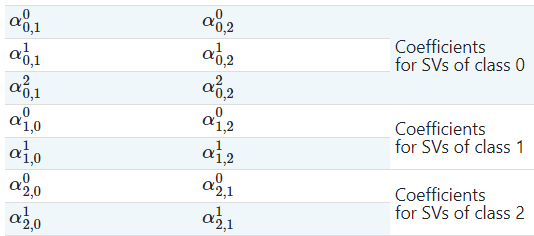

# Scores and probabilities

The decision_function method of SVC and NuSVC gives per-class scores for each sample (or a single score per sample in the binary case). When the constructor option probability is set to True, class membership probability estimates (from the methods predict_proba and predict_log_proba) are enabled. In the binary case, the probabilities are calibrated using Platt scaling 9: logistic regression on the SVM’s scores, fit by an additional cross-validation on the training data. In the multiclass case, this is extended as per.

The cross-validation involved in Platt scaling is an expensive operation for large datasets. In addition, the probability estimates may be inconsistent with the scores:

the “argmax” of the scores may not be the argmax of the probabilities

in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5.

Platt’s method is also known to have theoretical issues. If confidence scores are required, but these do not have to be probabilities, then it is advisable to set probability=False and use decision_function instead of predict_proba.

Please note that when decision_function_shape='ovr' and n_classes > 2, unlike decision_function, the predict method does not try to break ties by default. You can set break_ties=True for the output of predict to be the same as np.argmax(clf.decision_function(...), axis=1), otherwise the first class among the tied classes will always be returned; but have in mind that it comes with a computational cost. See SVM Tie Breaking Example for an example on tie breaking.

# Unbalanced problems

In problems where it is desired to give more importance to certain classes or certain individual samples, the parameters class_weight and sample_weight can be used.

SVC (but not NuSVC) implements the parameter class_weight in the fit method. It’s a dictionary of the form {class_label : value}, where value is a floating point number > 0 that sets the parameter C of class class_label to C * value. The figure below illustrates the decision boundary of an unbalanced problem, with and without weight correction.

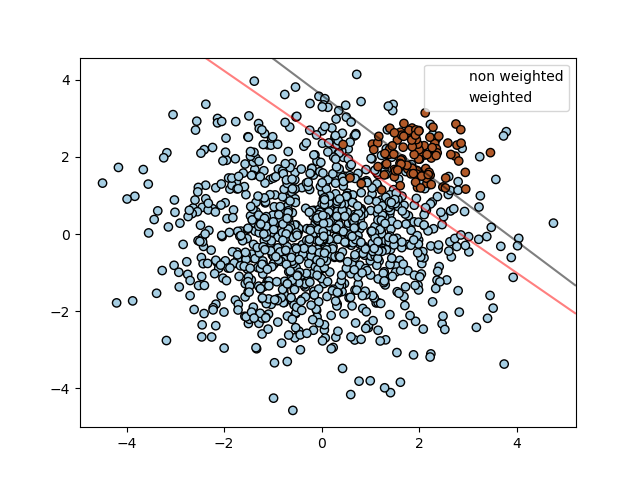

SVC, NuSVC, SVR, NuSVR, LinearSVC, LinearSVR and OneClassSVM implement also weights for individual samples in the fit method through the sample_weight parameter. Similar to class_weight, this sets the parameter C for the i-th example to C * sample_weight[i], which will encourage the classifier to get these samples right. The figure below illustrates the effect of sample weighting on the decision boundary. The size of the circles is proportional to the sample weights:



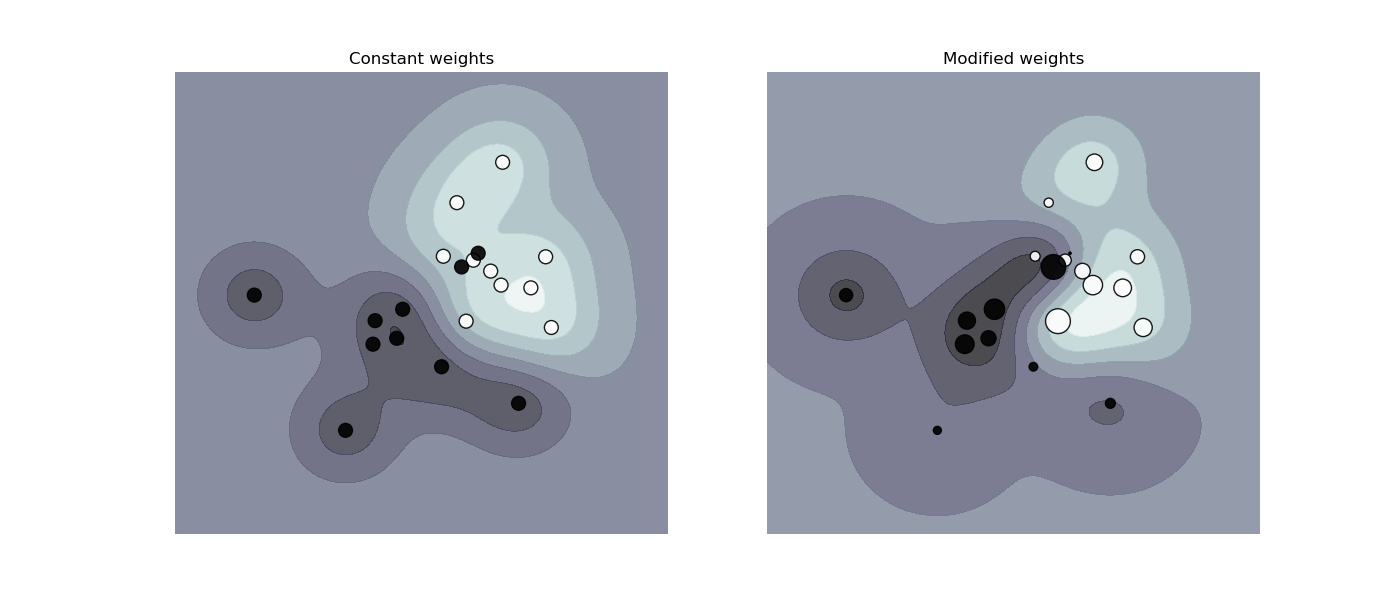

# Regression

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.

The model produced by support vector classification (as described above) depends only on a subset of the training data, because the cost function for building the model does not care about training points that lie beyond the margin. Analogously, the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.

There are three different implementations of Support Vector Regression: SVR, NuSVR and LinearSVR. LinearSVR provides a faster implementation than SVR but only considers the linear kernel, while NuSVR implements a slightly different formulation than SVR and LinearSVR. See Implementation details for further details.

As with classification classes, the fit method will take as argument vectors X, y, only that in this case y is expected to have floating point values instead of integer values:

In [9]:
# Regression
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
regr = svm.SVR()
regr.fit(X, y)

regr.predict([[1, 1]])


array([1.5])

# Density estimation, novelty detection
The class OneClassSVM implements a One-Class SVM which is used in outlier detection.

See Novelty and Outlier Detection for the description and usage of OneClassSVM.



# Complexity

Support Vector Machines are powerful tools, but their compute and storage requirements increase rapidly with the number of training vectors. The core of an SVM is a quadratic programming problem (QP), separating support vectors from the rest of the training data. The QP solver used by the libsvm-based implementation scales between 
 and 
 depending on how efficiently the libsvm cache is used in practice (dataset dependent). If the data is very sparse  should be replaced by the average number of non-zero features in a sample vector.

For the linear case, the algorithm used in LinearSVC by the liblinear implementation is much more efficient than its libsvm-based SVC counterpart and can scale almost linearly to millions of samples and/or features.

# Tips on Practical Use

Avoiding data copy: For SVC, SVR, NuSVC and NuSVR, if the data passed to certain methods is not C-ordered contiguous and double precision, it will be copied before calling the underlying C implementation. You can check whether a given numpy array is C-contiguous by inspecting its flags attribute.

For LinearSVC (and LogisticRegression) any input passed as a numpy array will be copied and converted to the liblinear internal sparse data representation (double precision floats and int32 indices of non-zero components). If you want to fit a large-scale linear classifier without copying a dense numpy C-contiguous double precision array as input, we suggest to use the SGDClassifier class instead. The objective function can be configured to be almost the same as the LinearSVC model.

Kernel cache size: For SVC, SVR, NuSVC and NuSVR, the size of the kernel cache has a strong impact on run times for larger problems. If you have enough RAM available, it is recommended to set cache_size to a higher value than the default of 200(MB), such as 500(MB) or 1000(MB).

Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.

LinearSVC and LinearSVR are less sensitive to C when it becomes large, and prediction results stop improving after a certain threshold. Meanwhile, larger C values will take more time to train, sometimes up to 10 times longer, as shown in 11.

Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline:

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC())

Regarding the shrinking parameter, quoting 12: We found that if the number of iterations is large, then shrinking can shorten the training time. However, if we loosely solve the optimization problem (e.g., by using a large stopping tolerance), the code without using shrinking may be much faster

Parameter nu in NuSVC/OneClassSVM/NuSVR approximates the fraction of training errors and support vectors.

In SVC, if the data is unbalanced (e.g. many positive and few negative), set class_weight='balanced' and/or try different penalty parameters C.

Randomness of the underlying implementations: The underlying implementations of SVC and NuSVC use a random number generator only to shuffle the data for probability estimation (when probability is set to True). This randomness can be controlled with the random_state parameter. If probability is set to False these estimators are not random and random_state has no effect on the results. The underlying OneClassSVM implementation is similar to the ones of SVC and NuSVC. As no probability estimation is provided for OneClassSVM, it is not random.

The underlying LinearSVC implementation uses a random number generator to select features when fitting the model with a dual coordinate descent (i.e when dual is set to True). It is thus not uncommon to have slightly different results for the same input data. If that happens, try with a smaller tol parameter. This randomness can also be controlled with the random_state parameter. When dual is set to False the underlying implementation of LinearSVC is not random and random_state has no effect on the results.

Using L1 penalization as provided by LinearSVC(penalty='l1', dual=False) yields a sparse solution, i.e. only a subset of feature weights is different from zero and contribute to the decision function. Increasing C yields a more complex model (more features are selected). The C value that yields a “null” model (all weights equal to zero) can be calculated using l1_min_c.

# Kernel functions

The kernel function can be any of the following:

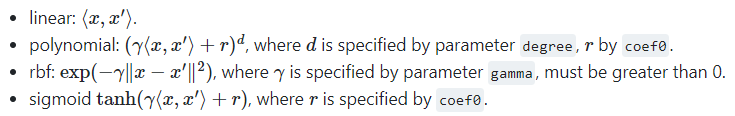


Different kernels are specified by the kernel parameter:

In [13]:
linear_svc = svm.SVC(kernel='linear')
linear_svc.kernel



'linear'

In [12]:
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.kernel

'rbf'

# Parameters of the RBF Kernel

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

# Custom Kernels

You can define your own kernels by either giving the kernel as a python function or by precomputing the Gram matrix.

Classifiers with custom kernels behave the same way as any other classifiers, except that:

Field support_vectors_ is now empty, only indices of support vectors are stored in support_

A reference (and not a copy) of the first argument in the fit() method is stored for future reference. If that array changes between the use of fit() and predict() you will have unexpected results.

# Using Python functions as kernels

You can use your own defined kernels by passing a function to the kernel parameter.

Your kernel must take as arguments two matrices of shape (n_samples_1, n_features), (n_samples_2, n_features) and return a kernel matrix of shape (n_samples_1, n_samples_2).

The following code defines a linear kernel and creates a classifier instance that will use that kernel:

In [14]:
import numpy as np
from sklearn import svm
def my_kernel(X, Y):
     return np.dot(X, Y.T)

clf = svm.SVC(kernel=my_kernel)

# Using the Gram matrix

You can pass pre-computed kernels by using the kernel='precomputed' option. You should then pass Gram matrix instead of X to the fit and predict methods. The kernel values between all training vectors and the test vectors must be provided:

In [15]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
X, y = make_classification(n_samples=10, random_state=0)
X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0)
clf = svm.SVC(kernel='precomputed')
# linear kernel computation
gram_train = np.dot(X_train, X_train.T)
clf.fit(gram_train, y_train)

SVC(kernel='precomputed')

In [16]:
# predict on training examples
gram_test = np.dot(X_test, X_train.T)
clf.predict(gram_test)

array([0, 1, 0])

Mathematical formulation
A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. The figure below shows the decision function for a linearly separable problem, with three samples on the margin boundaries, called “support vectors”:

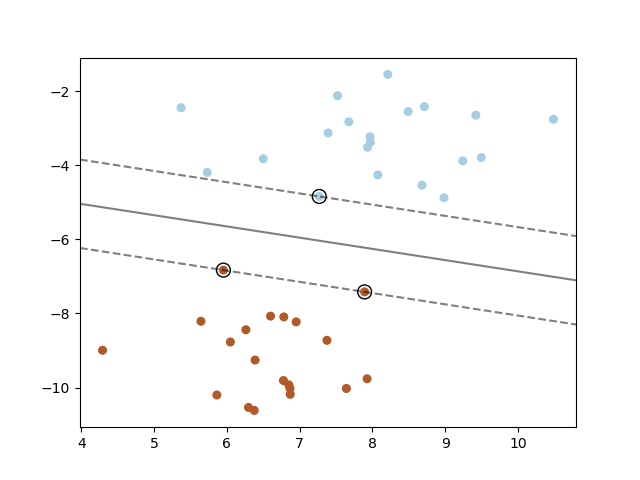



# SVC

Given training vectors $x_{i} \in \mathbb{R}^{p}$, $\mathrm{i}=1, \ldots, \mathrm{n}$, in two classes, and a vector $y \in\{1,-1\}^{n}$, our goal is to find $w \in \mathbb{R}^{p}$ and $b \in \mathbb{R}$ such that the prediction given by $\operatorname{sign}\left(w^{T} \phi(x)+b\right)$ is correct for most samples.
SVC solves the following primal problem:
$$
\begin{gathered}
\min _{w, b, \zeta} \frac{1}{2} w^{T} w+C \sum_{i=1}^{n} \zeta_{i} \\
\text { subject to } y_{i}\left(w^{T} \phi\left(x_{i}\right)+b\right) \geq 1-\zeta_{i} \\
\zeta_{i} \geq 0, i=1, \ldots, n
\end{gathered}
$$
Intuitively, we're trying to maximize the margin (by minimizing $\|w\|^{2}=w^{T} w$ ), while incurring a penalty when a sample is misclassified or within the margin boundary. Ideally, the value $y_{i}\left(w^{T} \phi\left(x_{i}\right)+b\right)$ would be $\geq 1$ for all samples, which indicates a perfect prediction. But problems are usually not always perfectly separable with a hyperplane, so we allow some samples to be at a distance $\zeta_{i}$ from their correct margin boundary. The penalty term c controls the strength of this penalty, and as a result, acts as an inverse regularization parameter (see note below).
The dual problem to the primal is
$$
\begin{gathered}
\min _{\alpha} \frac{1}{2} \alpha^{T} Q \alpha-e^{T} \alpha \\
\text { subject to } y^{T} \alpha=0 \\
0 \leq \alpha_{i} \leq C, i=1, \ldots, n
\end{gathered}
$$
where $e$ is the vector of all ones, and $Q$ is an $n$ by $n$ positive semidefinite matrix, $Q_{i j} \equiv y_{i} y_{j} K\left(x_{i}, x_{j}\right)$, where $K\left(x_{i}, x_{j}\right)=\phi\left(x_{i}\right)^{T} \phi\left(x_{j}\right)$ is the kernel. The terms $\alpha_{i}$ are called the dual coefficients, and they are upper-bounded by $C .$ This dual representation highlights the fact that training vectors are implicitly mapped into a higher (maybe infinite) dimensional space by the function $\phi$ : see kernel trick.
Once the optimization problem is solved, the output of decision_function for a given sample $x$ becomes:
$$
\sum_{i \in S V} y_{i} \alpha_{i} K\left(x_{i}, x\right)+b
$$
and the predicted class correspond to its sign. We only need to sum over the support vectors (i.e. the samples that lie within the margin) because the dual coefficients $\alpha_{i}$ are zero for the other samples.
These parameters can be accessed through the attributes dual_coef_which holds the product $y_{i} \alpha_{i}$, support_vectors_which holds the support vectors, and intercept_which holds the independent term $b$

LinearSVC
The primal problem can be equivalently formulated as

 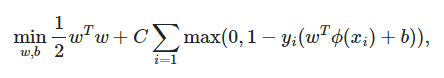
 
 
where we make use of the hinge loss. This is the form that is directly optimized by LinearSVC, but unlike the dual form, this one does not involve inner products between samples, so the famous kernel trick cannot be applied. This is why only the linear kernel is supported by LinearSVC ( is the identity function).




# NuSVC
The v-SVC formulation 15 is a reparameterization of the C-SVC and therefore mathematically equivalent.

We introduce a new parameter v (instead of C) which controls the number of support vectors and margin errors: $v \in \mathbb{R}^{p}$, $\mathrm{i}=1, \ldots, \mathrm{n}$ is an upper bound on the fraction of margin errors and a lower bound of the fraction of support vectors. A margin error corresponds to a sample that lies on the wrong side of its margin boundary: it is either misclassified, or it is correctly classified but does not lie beyond the margin.

# SVR

Given training vectors $x_{i} \in \mathbb{R}^{p}, \mathrm{i}=1, \ldots, \mathrm{n}$, and a vector $y \in \mathbb{R}^{n} \varepsilon$-SVR solves the following primal problem:
$$
\begin{array}{r}
\min _{w, b, \zeta, \zeta^{*}} \frac{1}{2} w^{T} w+C \sum_{i=1}^{n}\left(\zeta_{i}+\zeta_{i}^{*}\right) \\
\text { subject to } y_{i}-w^{T} \phi\left(x_{i}\right)-b \leq \varepsilon+\zeta_{i} \\
w^{T} \phi\left(x_{i}\right)+b-y_{i} \leq \varepsilon+\zeta_{i}^{*} \\
\zeta_{i}, \zeta_{i}^{*} \geq 0, i=1, \ldots, n
\end{array}
$$
Here, we are penalizing samples whose prediction is at least $\varepsilon$ away from their true target. These samples penalize the objective by $\zeta_{i}$ or $\zeta_{i}^{*}$, depending on whether their predictions lie above or below the $\varepsilon$ tube.
The dual problem is
$$
\begin{array}{r}
\min _{\alpha, \alpha^{*}} \frac{1}{2}\left(\alpha-\alpha^{*}\right)^{T} Q\left(\alpha-\alpha^{*}\right)+\varepsilon e^{T}\left(\alpha+\alpha^{*}\right)-y^{T}\left(\alpha-\alpha^{*}\right) \\
\text { subject to } e^{T}\left(\alpha-\alpha^{*}\right)=0 \\
0 \leq \alpha_{i}, \alpha_{i}^{*} \leq C, i=1, \ldots, n
\end{array}
$$
where $e$ is the vector of all ones, $Q$ is an $n$ by $n$ positive semidefinite matrix, $Q_{i j} \equiv K\left(x_{i}, x_{j}\right)=\phi\left(x_{i}\right)^{T} \phi\left(x_{j}\right)$ is the kernel. Here training vectors are implicitly mapped into a higher (maybe infinite) dimensional space by the function $\phi$.
The prediction is:
$$
\sum_{i \in S V}\left(\alpha_{i}-\alpha_{i}^{*}\right) K\left(x_{i}, x\right)+b
$$
These parameters can be accessed through the attributes dual_coef_which holds the difference $\alpha_{i}-\alpha_{i}^{*}$, support_vectors_which holds the support vectors, and intercept_which holds the independent term $b$
1.4.7.5. LinearSVR
The primal problem can be equivalently formulated as
$$
\min _{w, b} \frac{1}{2} w^{T} w+C \sum_{i=1} \max \left(0,\left|y_{i}-\left(w^{T} \phi\left(x_{i}\right)+b\right)\right|-\varepsilon\right)
$$
where we make use of the epsilon-insensitive loss, i.e. errors of less than $\varepsilon$ are ignored. This is the form that is directly optimized by LinearSVR.

![original image](https://cdn.mathpix.com/snip/images/3UCDBSV2a1BXntap5QQKhYHsXLWR83VDWjjEmwM1BEc.original.fullsize.png)

Given training vectors $x_{i} \in \mathbb{R}^{p}$, $\mathrm{i}=1, \ldots, \mathrm{n}$, in two classes, and a vector $y \in\{1,-1\}^{n}$, our goal is to find $w \in \mathbb{R}^{p}$ and $b \in \mathbb{R}$ such that the prediction given by $\operatorname{sign}\left(w^{T} \phi(x)+b\right)$ is correct for most samples.
SVC solves the following primal problem:
$$
\begin{gathered}
\min _{w, b, \zeta} \frac{1}{2} w^{T} w+C \sum_{i=1}^{n} \zeta_{i} \\
\text { subject to } y_{i}\left(w^{T} \phi\left(x_{i}\right)+b\right) \geq 1-\zeta_{i} \\
\zeta_{i} \geq 0, i=1, \ldots, n
\end{gathered}
$$
Intuitively, we're trying to maximize the margin (by minimizing $\|w\|^{2}=w^{T} w$ ), while incurring a penalty when a sample is misclassified or within the margin boundary. Ideally, the value $y_{i}\left(w^{T} \phi\left(x_{i}\right)+b\right)$ would be $\geq 1$ for all samples, which indicates a perfect prediction. But problems are usually not always perfectly separable with a hyperplane, so we allow some samples to be at a distance $\zeta_{i}$ from their correct margin boundary. The penalty term c controls the strength of this penalty, and as a result, acts as an inverse regularization parameter (see note below).
The dual problem to the primal is
$$
\begin{gathered}
\min _{\alpha} \frac{1}{2} \alpha^{T} Q \alpha-e^{T} \alpha \\
\text { subject to } y^{T} \alpha=0 \\
0 \leq \alpha_{i} \leq C, i=1, \ldots, n
\end{gathered}
$$
where $e$ is the vector of all ones, and $Q$ is an $n$ by $n$ positive semidefinite matrix, $Q_{i j} \equiv y_{i} y_{j} K\left(x_{i}, x_{j}\right)$, where $K\left(x_{i}, x_{j}\right)=\phi\left(x_{i}\right)^{T} \phi\left(x_{j}\right)$ is the kernel. The terms $\alpha_{i}$ are called the dual coefficients, and they are upper-bounded by $C .$ This dual representation highlights the fact that training vectors are implicitly mapped into a higher (maybe infinite) dimensional space by the function $\phi$ : see kernel trick.
Once the optimization problem is solved, the output of decision_function for a given sample $x$ becomes:
$$
\sum_{i \in S V} y_{i} \alpha_{i} K\left(x_{i}, x\right)+b
$$
and the predicted class correspond to its sign. We only need to sum over the support vectors (i.e. the samples that lie within the margin) because the dual coefficients $\alpha_{i}$ are zero for the other samples.
These parameters can be accessed through the attributes dual_coef_which holds the product $y_{i} \alpha_{i}$, support_vectors_which holds the support vectors, and intercept_which holds the independent term $b$

# LinearSVR
The primal problem can be equivalently formulated as:
    
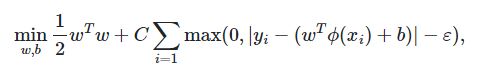

where we make use of the epsilon-insensitive loss, i.e. errors of less than  are ignored. This is the form that is directly optimized by LinearSVR.

# 2. One-class SVM with non-linear kernel (RBF).
# -----------------------------------------------------------------------------------------------------------

An example using a one-class SVM for novelty detection.

One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

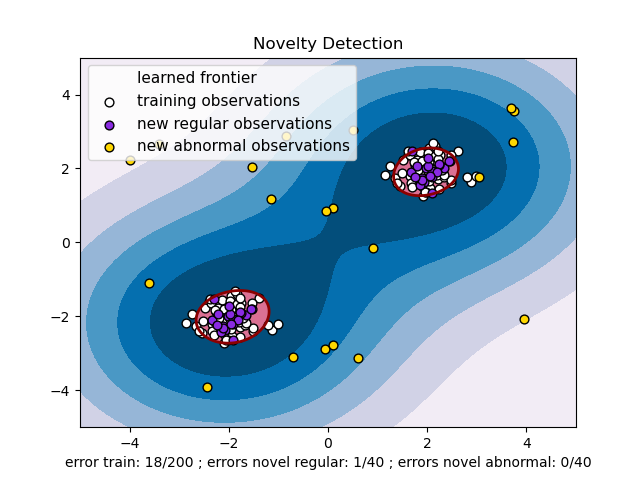




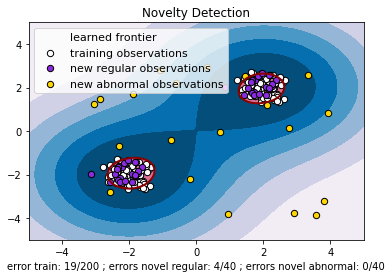

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [a.collections[0], b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers)
)
plt.show()

# 3. SVM Margins Example
# -----------------------------------------------------------------------------------------------------------

The plots below illustrate the effect the parameter C has on the separation line. A large value of C basically tells our model that we do not have that much faith in our data’s distribution, and will only consider points close to line of separation.

A small value of C includes more/all the observations, allowing the margins to be calculated using all the data in the area.

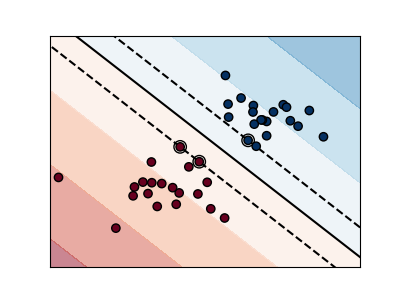



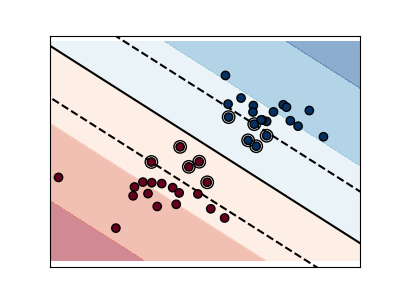

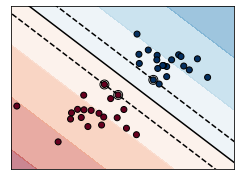

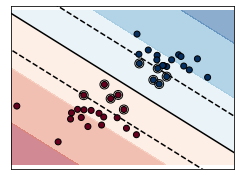

In [21]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import svm

# we create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# figure number
fignum = 1

# fit the model
for name, penalty in (("unreg", 1), ("reg", 0.05)):

    clf = svm.SVC(kernel="linear", C=penalty)
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
    # 2-d.
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")

    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
        cmap=cm.get_cmap("RdBu"),
    )
    plt.scatter(
        X[:, 0], X[:, 1], c=Y, zorder=10, cmap=cm.get_cmap("RdBu"), edgecolors="k"
    )

    plt.axis("tight")
    x_min = -4.8
    x_max = 4.2
    y_min = -6
    y_max = 6

    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Put the result into a contour plot
    plt.contourf(XX, YY, Z, cmap=cm.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1

plt.show()

# 4. Non-linear SVM.
# -----------------------------------------------------------------------------------------------------------

Perform binary classification using non-linear SVC with RBF kernel. The target to predict is a XOR of the inputs.

The color map illustrates the decision function learned by the SVC.

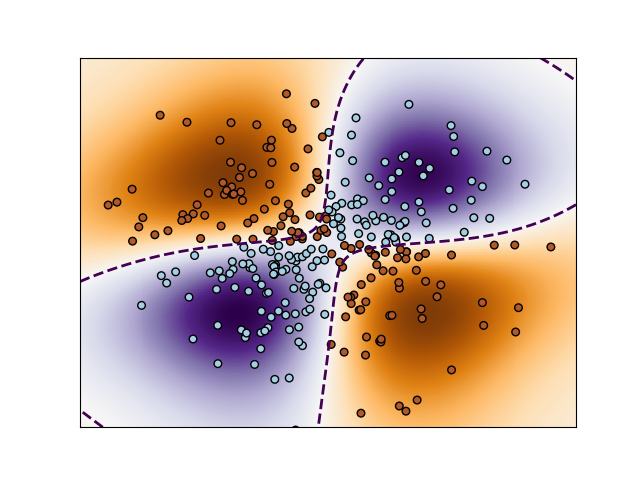

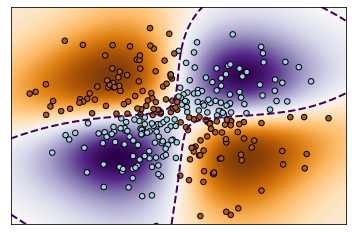

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

# 5. SVM Tie Breaking Example.
# -----------------------------------------------------------------------------------------------------------

Tie breaking is costly if ``decision_function_shape='ovr'``, and therefore it
is not enabled by default. This example illustrates the effect of the
``break_ties`` parameter for a multiclass classification problem and
``decision_function_shape='ovr'``.

The two plots differ only in the area in the middle where the classes are
tied. If ``break_ties=False``, all input in that area would be classified as
one class, whereas if ``break_ties=True``, the tie-breaking mechanism will
create a non-convex decision boundary in that area.


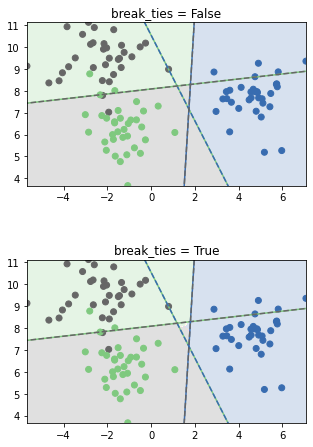

In [1]:
# Code source: Andreas Mueller, Adrin Jalali
# License: BSD 3 clause

#Carga de librerias a usar
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.datasets import make_blobs
# Se genera los datos de entrada y salida
X, y = make_blobs(random_state=27)

#Se define el marco para la grafica
fig, sub = plt.subplots(2, 1, figsize=(5, 8))
titles = ("break_ties = False", "break_ties = True")

for break_ties, title, ax in zip((False, True), titles, sub.flatten()):

    svm = SVC(
        kernel="linear", C=1, break_ties=break_ties, decision_function_shape="ovr"
    ).fit(X, y)

    xlim = [X[:, 0].min(), X[:, 0].max()]
    ylim = [X[:, 1].min(), X[:, 1].max()]

    xs = np.linspace(xlim[0], xlim[1], 1000)
    ys = np.linspace(ylim[0], ylim[1], 1000)
    xx, yy = np.meshgrid(xs, ys)

    pred = svm.predict(np.c_[xx.ravel(), yy.ravel()])

    colors = [plt.cm.Accent(i) for i in [0, 4, 7]]

    points = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
    classes = [(0, 1), (0, 2), (1, 2)]
    line = np.linspace(X[:, 1].min() - 5, X[:, 1].max() + 5)
    ax.imshow(
        -pred.reshape(xx.shape),
        cmap="Accent",
        alpha=0.2,
        extent=(xlim[0], xlim[1], ylim[1], ylim[0]),
    )

    for coef, intercept, col in zip(svm.coef_, svm.intercept_, classes):
        line2 = -(line * coef[1] + intercept) / coef[0]
        ax.plot(line2, line, "-", c=colors[col[0]])
        ax.plot(line2, line, "--", c=colors[col[1]])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_aspect("equal")

plt.show()


# 6.SVM: Separating hyperplane for unbalanced classes
# -----------------------------------------------------------------------------------------------------------

Find the optimal separating hyperplane using an SVC for classes that
are unbalanced.

We first find the separating plane with a plain SVC and then plot
(dashed) the separating hyperplane with automatically correction for
unbalanced classes.

.. currentmodule:: sklearn.linear_model

<div class="alert alert-info"><h4>Note</h4><p>This example will also work by replacing ``SVC(kernel="linear")``
    with ``SGDClassifier(loss="hinge")``. Setting the ``loss`` parameter
    of the :class:`SGDClassifier` equal to ``hinge`` will yield behaviour
    such as that of a SVC with a linear kernel.

    For example try instead of the ``SVC``::

        clf = SGDClassifier(n_iter=100, alpha=0.01)</p></div>

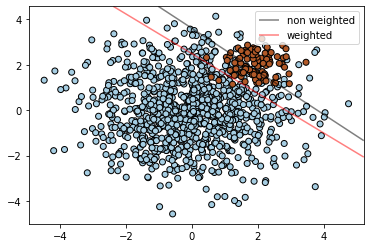

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

# we create two clusters of random points
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)

# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 10})
wclf.fit(X, y)

# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

# plot the decision functions for both classifiers
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# get the separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, colors="k", levels=[0], alpha=0.5, linestyles=["-"])

# get the separating hyperplane for weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins for weighted classes
b = ax.contour(XX, YY, Z, colors="r", levels=[0], alpha=0.5, linestyles=["-"])

plt.legend(
    [a.collections[0], b.collections[0]],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()


# 7.SVM: Weighted samples
# -----------------------------------------------------------------------------------------------------------


Plot decision function of a weighted dataset, where the size of points
is proportional to its weight.

The sample weighting rescales the C parameter, which means that the classifier
puts more emphasis on getting these points right. The effect might often be
subtle.
To emphasize the effect here, we particularly weight outliers, making the
deformation of the decision boundary very visible.

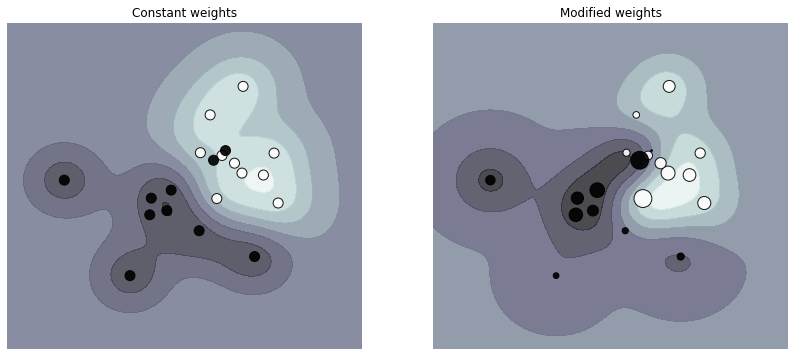

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bone,
        edgecolors="black",
    )

    axis.axis("off")
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights

# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(
    clf_no_weights, sample_weight_constant, axes[0], "Constant weights"
)
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1], "Modified weights")

plt.show()


# 8.Outlier detection on a real data set
# -----------------------------------------------------------------------------------------------------------

This example illustrates the need for robust covariance estimation
on a real data set. It is useful both for outlier detection and for
a better understanding of the data structure.

We selected two sets of two variables from the Wine data set
as an illustration of what kind of analysis can be done with several
outlier detection tools. For the purpose of visualization, we are working
with two-dimensional examples, but one should be aware that things are
not so trivial in high-dimension, as it will be pointed out.

In both examples below, the main result is that the empirical covariance
estimate, as a non-robust one, is highly influenced by the heterogeneous
structure of the observations. Although the robust covariance estimate is
able to focus on the main mode of the data distribution, it sticks to the
assumption that the data should be Gaussian distributed, yielding some biased
estimation of the data structure, but yet accurate to some extent.
The One-Class SVM does not assume any parametric form of the data distribution
and can therefore model the complex shape of the data much better.

## First example
The first example illustrates how the Minimum Covariance Determinant
robust estimator can help concentrate on a relevant cluster when outlying
points exist. Here the empirical covariance estimation is skewed by points
outside of the main cluster. Of course, some screening tools would have pointed
out the presence of two clusters (Support Vector Machines, Gaussian Mixture
Models, univariate outlier detection, ...). But had it been a high-dimensional
example, none of these could be applied that easily.

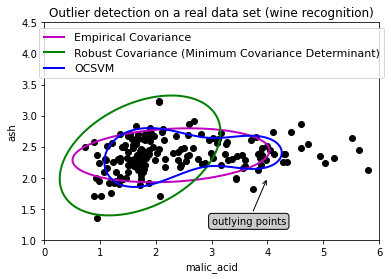

In [4]:
# Author: Virgile Fritsch <virgile.fritsch@inria.fr>
# License: BSD 3 clause

import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_wine

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(
        contamination=0.25
    ),
    "OCSVM": OneClassSVM(nu=0.25, gamma=0.35),
}
colors = ["m", "g", "b"]
legend1 = {}
legend2 = {}

# Get data
X1 = load_wine()["data"][:, [1, 2]]  # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (wine recognition)")
plt.scatter(X1[:, 0], X1[:, 1], color="black")
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(4, 2),
    xycoords="data",
    textcoords="data",
    xytext=(3, 1.25),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend(
    (
        legend1_values_list[0].collections[0],
        legend1_values_list[1].collections[0],
        legend1_values_list[2].collections[0],
    ),
    (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("ash")
plt.xlabel("malic_acid")

plt.show()

## Second example
The second example shows the ability of the Minimum Covariance Determinant
robust estimator of covariance to concentrate on the main mode of the data
distribution: the location seems to be well estimated, although the
covariance is hard to estimate due to the banana-shaped distribution. Anyway,
we can get rid of some outlying observations. The One-Class SVM is able to
capture the real data structure, but the difficulty is to adjust its kernel
bandwidth parameter so as to obtain a good compromise between the shape of
the data scatter matrix and the risk of over-fitting the data.

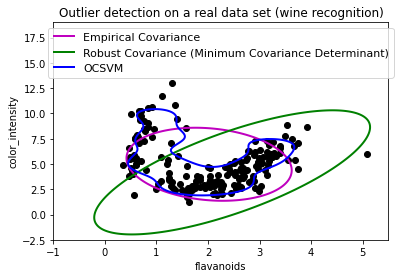

In [5]:
# Get data
X2 = load_wine()["data"][:, [6, 9]]  # "banana"-shaped

# Learn a frontier for outlier detection with several classifiers
xx2, yy2 = np.meshgrid(np.linspace(-1, 5.5, 500), np.linspace(-2.5, 19, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i]
    )

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(2)  # "banana" shape
plt.title("Outlier detection on a real data set (wine recognition)")
plt.scatter(X2[:, 0], X2[:, 1], color="black")
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend(
    (
        legend2_values_list[0].collections[0],
        legend2_values_list[1].collections[0],
        legend2_values_list[2].collections[0],
    ),
    (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2]),
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("color_intensity")
plt.xlabel("flavanoids")

plt.show()

# 9.Plot different SVM classifiers in the iris dataset
# -----------------------------------------------------------------------------------------------------------

Comparison of different linear SVM classifiers on a 2D projection of the iris
dataset. We only consider the first 2 features of this dataset:

- Sepal length
- Sepal width

This example shows how to plot the decision surface for four SVM classifiers
with different kernels.

The linear models ``LinearSVC()`` and ``SVC(kernel='linear')`` yield slightly
different decision boundaries. This can be a consequence of the following
differences:

- ``LinearSVC`` minimizes the squared hinge loss while ``SVC`` minimizes the
  regular hinge loss.

- ``LinearSVC`` uses the One-vs-All (also known as One-vs-Rest) multiclass
  reduction while ``SVC`` uses the One-vs-One multiclass reduction.

Both linear models have linear decision boundaries (intersecting hyperplanes)
while the non-linear kernel models (polynomial or Gaussian RBF) have more
flexible non-linear decision boundaries with shapes that depend on the kind of
kernel and its parameters.

.. NOTE:: while plotting the decision function of classifiers for toy 2D
   datasets can help get an intuitive understanding of their respective
   expressive power, be aware that those intuitions don't always generalize to
   more realistic high-dimensional problems.

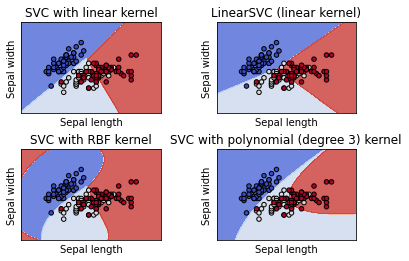

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("Sepal length")
    ax.set_ylabel("Sepal width")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()